# Example 2: -  Analyzing dim6 operators in WBF 

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we will demonstrate further functionalities of MadMiner. In particular we show how
- to include smearing at parton level
- to include backgrounds

## Preparations

Let us first load all the python libraries again

In [18]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis
from madminer.sampling import combine_and_shuffle
from madminer.lhe import LHEProcessor
from madminer.sampling import SampleAugmenter
from madminer.plotting import plot_distributions

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5. **This needs to be updated by the user**

In [2]:
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

## 1. Setup

### 1a) Define parameter space

Let us first define the theory parameters. Note the additional option `param_card_transform`, which can transform the theory parameter in MadMiner (`theta`) to the input parameter in the param_card. In this case we re-scale from GeV$^{-2}$ to TeV$^{-2}$. 

In [3]:
miner = MadMiner()

miner.add_parameter(
    lha_block='anoinputs',
    lha_id=3,
    parameter_name='FW',
    morphing_max_power=2,
    param_card_transform="0.000001*theta",
    parameter_range=(-10,10)
)
miner.add_parameter(
    lha_block='anoinputs',
    lha_id=7,
    parameter_name='FWW',
    morphing_max_power=2,
    param_card_transform="0.000001*theta",
    parameter_range=(-10,10)
)

### 1b) Define benchmark points (evaluation points for |M|^2)

Define morphing benchmarks by hand / per scan. 

In [4]:
miner.add_benchmark(
    {'FW':0., 'FWW':0.},
    'sm'
)
miner.add_benchmark(
    {'FW':2, 'FWW':2},
    'w'
)

In [5]:
miner.set_morphing(
    include_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

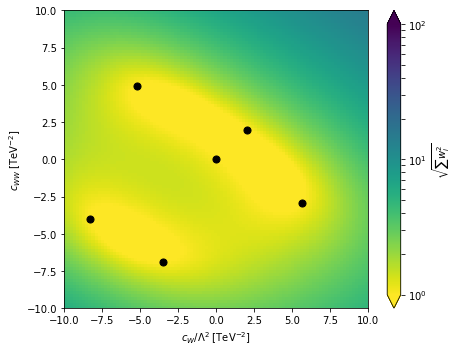

In [6]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{WW}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-10,10),
    yrange=(-10,10)
)

### 1c) Save setup

In [7]:
miner.save('data/madminer_example.h5')

### 1d) Comment on change UFO model to include detector smearing

To simulate the resolution of the invariant masses due to detector smearing, we use a simple trick: we change the Higgs propagator to reproduce the wanted (smeared) invariant mass distribution. The following example illustrates how to change the UFO model `dim6_for_information_parton` to reproduce the invariant mass distribution for $H\to\gamma\gamma$. 

1. We base our simulation of detector effects on the CMS simulation in Fig. 6 (right) of [CMS-PAS-HIG-15-005](https://cds.cern.ch/record/2140979). In particular, we describe the peak region of the $H\to\gamma\gamma$ diphoton mass distribution by a Gaussian 

    \begin{equation}
    Gaus\left(m~|~N,m_H,\sigma\right)=\frac{N}{\sqrt{2\pi}\sigma}\text{Exp}\left[-\frac{1}{2} \left(\frac{m-m_H}{\sigma}\right)^2\right].
    \end{equation}
    
    From a fit to the normalized distribution we obtain: $N=0.92$, $m_H=124.7$ and $\sigma=1.67$. The normalization factor $N$ accounts for the fact, that a gaussian does not describe the tails of the dsitribition well. However, these tails will hardly contribute to the information and we account for the loss of signal rate in these tails through the normalization factor $N$. 


2. We now replace the usual Breit-Wigner propagator with the (square-root) of the Gaussian distribution: 
    
    \begin{equation} 
    \frac{1}{p^2-m_H^2+i \Gamma m_H} \rightarrow \big[\frac{N}{N_{BW}}\frac{1}{\sqrt{2\pi}\sigma}\big]^{1/2} \text{Exp}\left[-\frac{1}{4} \left(\frac{m-m_H}{\sigma}\right)^2\right].
    \end{equation} 
    
    The normalization of the Breit-Wigner is given by  $N_{BW}\approx 2 m_H^2 \Gamma_H / \pi $.  (Here I used $\Gamma_H \ll m_H$. For full formula see [Wikipedia](https://en.wikipedia.org/wiki/Relativistic_Breit%E2%80%93Wigner_distribution)). 
    
    This can simply be implemented in the file `propagators.py` of the UFO model. First define the new propagator. Here I use the values obtained from the fit above and choose the prefactor $(\sqrt{2\pi}\sigma N_{BW} / N)^{1/2} = 12.438$ 
    
    `denominator_Higgs="12.438*cmath.exp(0.25*(cmath.sqrt(P('mu',id)*P('mu',id))-124.7)**2/1.5245**2)" `
    
    Assign the new propagator to to the scalar particles  
    
    `S = Propagator(name = "S",numerator = "complex(0,1)",denominator = denominator_Higgs)`


3. By defaukt, MadGraph doesn't use the content of `propagators.py`. So we have to make sure it's used. This can simply be done by changing the particle information in the `particles.py` file of the UFO model

    `H = Particle(pdg_code = 25, name = 'H', ... , propagator = Prop.S)`
    
    
4. Finally, we will change the `bwcutoff` in `run_card.dat` to ensure that MadGraph integrated over the desired range. The choice of `bwcutoff` depends on the choosen value of the Higgs width in the `param_card.dat`. For $\Gamma_H=4.07$ MeV I would suggest to choose `bwcutoff=2000`, which then covers an integration range of $m_H \pm 2000\times \Gamma_H = 116.9\dots 133.1$ GeV. 

    Note: if you get an error message such as `IEEE_UNDERFLOW_FLAG` or `IEEE_DENORMAL`, it probably means you have choosen a too large value for `bwcutoff`

## 2. Event Generation

Load MadMiner again

In [8]:
miner = MadMiner(debug=False)
miner.load('data/madminer_example.h5')

We now run MadMiner for the signal. Note that we call a new model file from the `ufo_model_directory`.

Here we introduce a new option  `MadMiner.run_multiple()`, which allows to start multiple runs with different run cards or different choices of `sample_benchmark`. In the following example, we will run MadMiner `nrun` times with the same run_card and the same sampling benchmark. 

In [9]:
nrun=5

miner.run_multiple(
    mg_directory=mg_dir,
    log_directory='logs/wbf_signal',
    mg_process_directory='./mg_processes/wbf_signal',
    proc_card_file='cards/proc_card_wbf_signal.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_files=['cards/run_card_wbf_signal.dat' for i in range(nrun)],
    pythia8_card_file=None,
    ufo_model_directory='cards/dim6_for_information_parton',
    sample_benchmarks=['sm'],
    initial_command='source ~/.bashrc'
)

It is possible to start multiple processes based on the same `MadMiner` instance. This can be used to combine samples sampled according to different benchmarks, and to add reducible backgrounds. 

For the latter, a useful option is the `is_background` switch, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

In [10]:
miner.run_multiple(
    mg_directory=mg_dir,
    log_directory='logs/ggF_background',
    mg_process_directory='./mg_processes/ggF_background',
    proc_card_file='cards/proc_card_ggF_background.dat',
    param_card_template_file='cards/param_card_template.dat',    
    run_card_files=['cards/run_card_ggF_background.dat' for i in range(nrun)],
    pythia8_card_file=None,    
    ufo_model_directory='cards/dim6_for_information_parton',
    sample_benchmarks=['sm'],
    is_background=True,
    initial_command='source ~/.bashrc'
)

## 3. Extract Parton Level Observables / Weights 

### 3a) Defining observables

Let us first define observables. We will do that as a function, which we then can use for both signal and backgrounds. 

In [5]:
def setup_observables(lhep):
    lhep.add_observable('pt_jhard', '(p[0].pt>p[1].pt)*p[0].pt+(p[0].pt<p[1].pt)*p[1].pt')
    lhep.add_observable('pt_jsoft', '(p[0].pt<p[1].pt)*p[0].pt+(p[0].pt>p[1].pt)*p[1].pt')
    lhep.add_observable('dphijj' , 'abs(p[0].deltaphi(p[1]))')
    lhep.add_observable('m_aa' , '(p[2] + p[3]).m')
    lhep.add_observable('m_jj' , '(p[0] + p[1]).m')
    lhep.add_observable('m_jjaa', '(p[0] + p[1] + p[2] + p[3]).m')
    lhep.add_observable('deta_jj', 'abs(p[0].eta - p[1].eta)')

    lhep.add_observable('px_j1', 'p[0].px')
    lhep.add_observable('px_j2', 'p[1].px')
    lhep.add_observable('px_a1', 'p[2].px')
    lhep.add_observable('px_a2', 'p[3].px')
    lhep.add_observable('px_h' , '(p[2]+p[3]).px')

    lhep.add_observable('py_j1', 'p[0].py')
    lhep.add_observable('py_j2', 'p[1].py')
    lhep.add_observable('py_a1', 'p[2].py')
    lhep.add_observable('py_a2', 'p[3].py')
    lhep.add_observable('py_h' , '(p[2]+p[3]).py')

    lhep.add_observable('pz_j1', 'p[0].pz')
    lhep.add_observable('pz_j2', 'p[1].pz')
    lhep.add_observable('pz_a1', 'p[2].pz')
    lhep.add_observable('pz_a2', 'p[3].pz')
    lhep.add_observable('pz_h' , '(p[2]+p[3]).pz')

    lhep.add_observable('en_j1', 'p[0].e')
    lhep.add_observable('en_j2', 'p[1].e')
    lhep.add_observable('en_a1', 'p[2].e')
    lhep.add_observable('en_a2', 'p[3].e')
    lhep.add_observable('en_h' , '(p[2]+p[3]).e')

    lhep.add_observable('pt_j1', 'p[0].pt')
    lhep.add_observable('pt_j2', 'p[1].pt')
    lhep.add_observable('pt_a1', 'p[2].pt')
    lhep.add_observable('pt_a2', 'p[3].pt')
    lhep.add_observable('pt_h' , '(p[2]+p[3]).pt')

    lhep.add_observable('eta_j1', 'p[0].eta')
    lhep.add_observable('eta_j2', 'p[1].eta')
    lhep.add_observable('eta_a1', 'p[2].eta')
    lhep.add_observable('eta_a2', 'p[3].eta')
    lhep.add_observable('eta_h' , '(p[2]+p[3]).eta')

    lhep.add_observable('dphi_j1j2', 'p[0].deltaphi(p[1])')
    lhep.add_observable('dphi_j1j2', 'p[0].deltaphi(p[1])')
    lhep.add_observable('dphi_a1a2', 'p[2].deltaphi(p[3])')
    lhep.add_observable('dphi_j1h' , 'p[0].deltaphi(p[2]+p[3])')
    lhep.add_observable('dphi_j2h' , 'p[1].deltaphi(p[2]+p[3])')

### 3b) Setting up and run LHEProcessor for Signal

Set up the processor. Here we include multiple LHE files

In [13]:
lhep = LHEProcessor('data/madminer_example.h5')
for run in range (nrun):
    run_str = str(run+1)
    if len(run_str) < 2:
        run_str = '0' + run_str
    lhep.add_sample(
        'mg_processes/wbf_signal/Events/run_{}/unweighted_events.lhe.gz'.format(run_str),
        sampled_from_benchmark="sm",
        k_factor=1./nrun)

Add observbales, analyse samples and save

In [14]:
setup_observables(lhep)

In [16]:
lhep.analyse_samples()
lhep.save('data/madminer_lhedata_wbf_signal.h5')

Let's make a quick cross check by plotting a distributions 

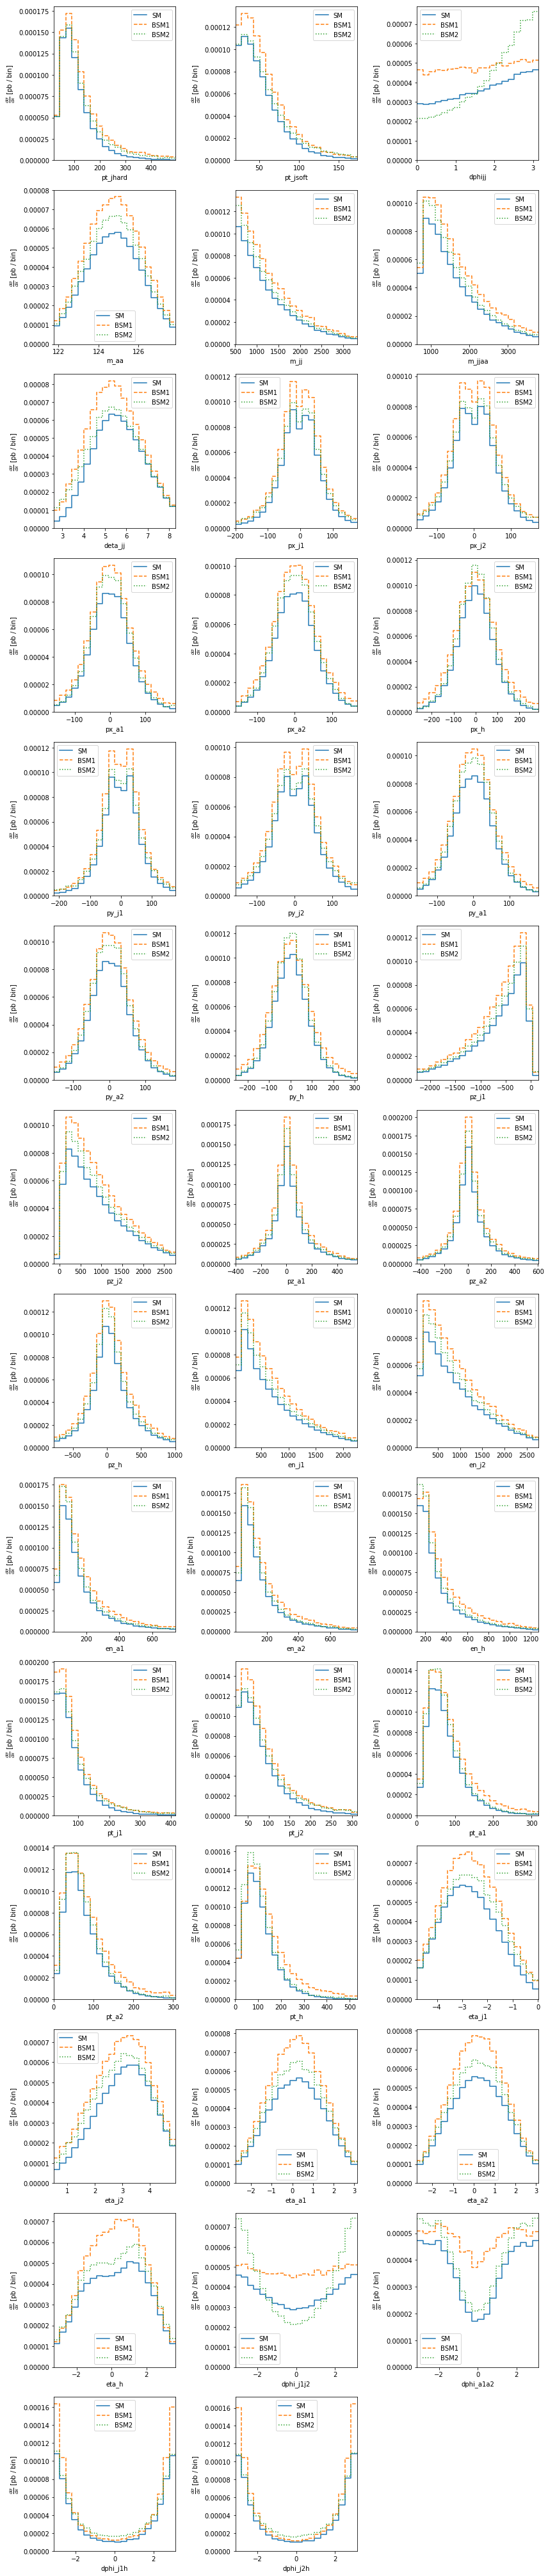

In [19]:
_ = plot_distributions(
    filename='data/madminer_lhedata_wbf_signal.h5',
    parameter_points=['sm',  np.array([10.,0.]), np.array([0.,10.])],
    line_labels=['SM', 'BSM1','BSM2'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=False
)

### 3c) Cross Check: Does the smearing work? 

Here I explicitly check the smearing of the mass peak and compare it to the wanted distribution obtained from the experimental collaboration. 

The total cross section is: 0.000727 pb


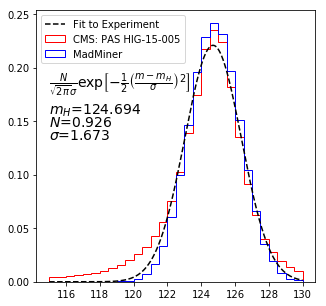

In [27]:
#Define my fitting function
def myfunction(x, mean, amplitude, standard_deviation):
    return amplitude/np.sqrt(2.0*3.1415*standard_deviation**2) * np.exp( - 0.5*((x - mean) / standard_deviation) ** 2)

#Function to do the plotting
def smearing_validation_plot(filename,lheprocessor,inputrange,label):
    
    #Get Data from Experiment / MadMiner
    exp_data , exp_weights = np.loadtxt(filename)[:,0] , np.loadtxt(filename)[:,1]
    madminer_data , madminer_weights = lheprocessor.observations['m_aa'] , lheprocessor.weights['sm']

    #Plot Exp. Data
    fig = plt.figure(figsize=(5,5))
    bin_heights, bin_borders, _ = plt.hist(exp_data, weights=exp_weights,normed=True,
        range=(inputrange[0],inputrange[1]), bins=inputrange[2], 
        histtype='step',color='Red',label=label)

    #Fit to Experiment
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    bestfit, _ = curve_fit(myfunction, bin_centers, bin_heights, p0=[125, 1, 1])
    fitplotrange=np.arange(inputrange[0], inputrange[1], 0.01)
    plt.plot(fitplotrange,myfunction(fitplotrange,bestfit[0],bestfit[1],bestfit[2]),
        color='Black',linestyle='dashed', label='Fit to Experiment')
    
    #Plot MadMiner
    norm = sum(madminer_weights)
    print ('The total cross section is: %.6f pb'%(norm),)
    bin_heights_mm, _ , _ = plt.hist(madminer_data,
        weights = madminer_weights/norm*inputrange[2]/(inputrange[1]-inputrange[0])*bestfit[1],
        range=(inputrange[0],inputrange[1]), bins=inputrange[2], 
         histtype='step',color='Blue',label='MadMiner')  

    #Finish Plot
    plt.legend(loc='upper left')
    upperbound=max(max(bin_heights),max(bin_heights_mm))
    plt.text(inputrange[0],0.75*upperbound,
         r'$\frac{N}{\sqrt{2\pi}\sigma}\exp\left[-\frac{1}{2}\left(\frac{m-m_H}{\sigma}\right)^2\right]$',
         fontsize=14)
    plt.text(inputrange[0],0.65*upperbound,r'$m_H$=%.3f'%(bestfit[0]),fontsize=14)
    plt.text(inputrange[0],0.60*upperbound,r'$N$=%.3f'%(bestfit[1]),fontsize=14)
    plt.text(inputrange[0],0.55*upperbound,r'$\sigma$=%.3f'%(bestfit[2]),fontsize=14)

    plt.show()

#Call Function
smearing_validation_plot('cards/smearing_data/h_2_aa.txt',lhep,[115,130,30],'CMS: PAS HIG-15-005')

### 3d) Setting up and run LHEProcessor for Background

Repeat procedure for ggF background

In [30]:
lhep = LHEProcessor('data/madminer_example.h5')

for run in range (nrun):
    run_str = str(run+1)
    if len(run_str) < 2:
        run_str = '0' + run_str
    lhep.add_sample(
        'mg_processes/ggF_background/Events/run_{}/unweighted_events.lhe.gz'.format(run_str),
        sampled_from_benchmark="sm",
        is_background=True,
        k_factor=1./nrun)
    
setup_observables(lhep)
lhep.analyse_samples()
lhep.save('data/madminer_lhedata_ggF_background.h5')

Cross check plots

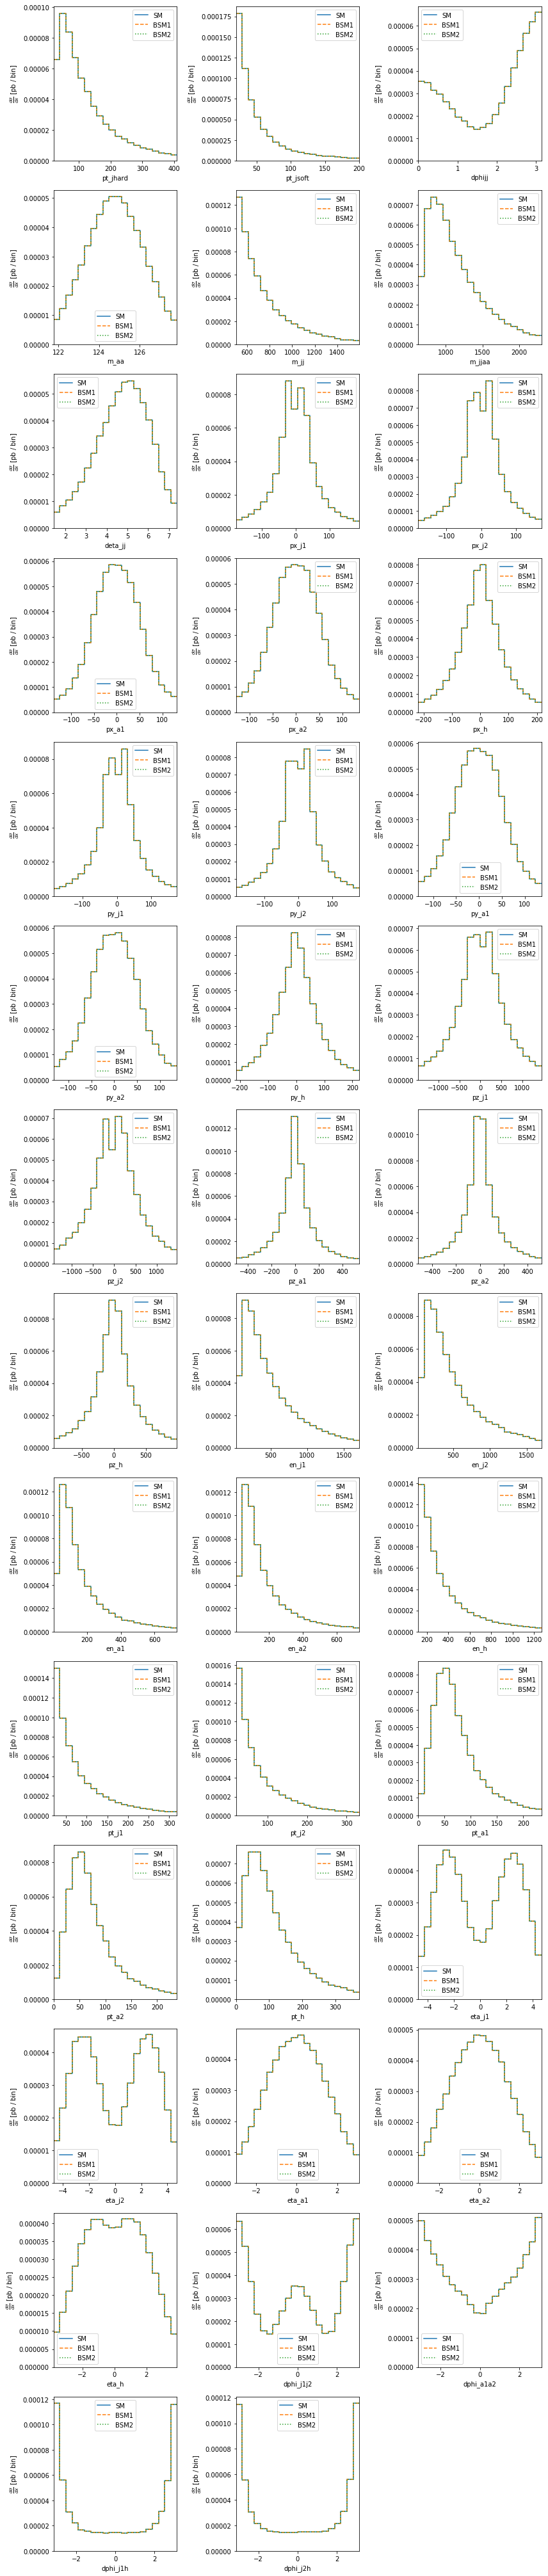

In [32]:
_ = plot_distributions(
    filename='data/madminer_lhedata_ggF_background.h5',
    parameter_points=['sm',  np.array([10.,0.]), np.array([0.,10.])],
    line_labels=['SM', 'BSM1','BSM2'],
    uncertainties='none',
    n_bins=20,
    n_cols=3,
    normalize=False
)

Smearing Plot

The total cross section is: 0.000632 pb


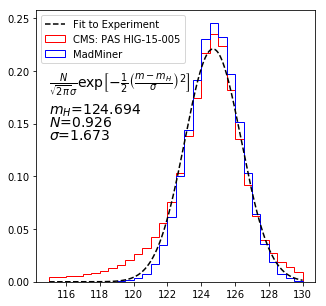

In [33]:
smearing_validation_plot('cards/smearing_data/h_2_aa.txt',lhep,[115,130,30],'CMS: PAS HIG-15-005')

### 3e) Plot Distributions

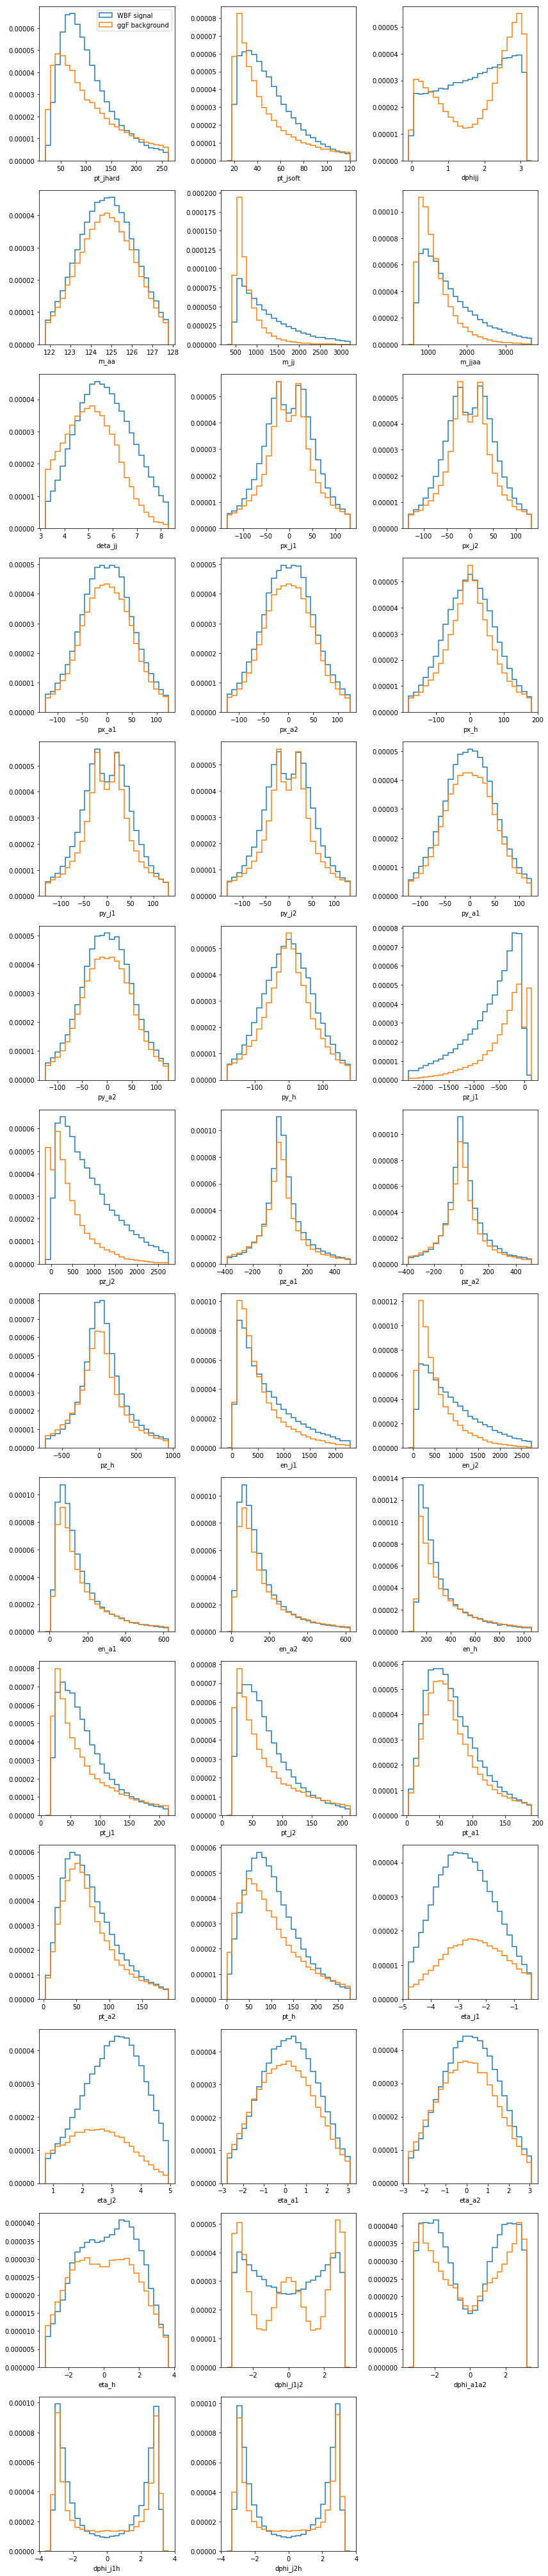

In [34]:
sa_wbf = SampleAugmenter('data/madminer_lhedata_wbf_signal.h5', debug=False)
sa_ggF = SampleAugmenter('data/madminer_lhedata_ggF_background.h5', debug=False)
x_weighted_wbf, weights_wbf = sa_wbf.extract_raw_data(theta=[0.,0.])
x_weighted_ggF, weights_ggF = sa_ggF.extract_raw_data(theta=[0.,0.])

bins = 25
n_observables = x_weighted_wbf.shape[1]
n_cols = 3
n_rows = (n_observables + n_cols - 1) // n_cols
labels = sa_wbf.observables.keys()

plt.figure(figsize=(4. * n_cols, 4. * n_rows))

for i, label in enumerate(labels):
    xmin = np.percentile(x_weighted_wbf[:,i], 5.)
    xmax = np.percentile(x_weighted_wbf[:,i], 95.)
    xwidth = xmax - xmin
    xmin -= xwidth * 0.1
    xmax += xwidth * 0.1
    x_range = (xmin, xmax)
    
    ax = plt.subplot(n_rows, n_cols, i+1)
       
    plt.hist(x_weighted_wbf[:,i], weights=weights_wbf, histtype='step', range=x_range, bins=bins, 
             lw=1.5, label=r'WBF signal', normed=False)
    plt.hist(x_weighted_ggF[:,i], weights=weights_ggF, histtype='step', range=x_range, bins=bins, 
             lw=1.5, label=r'ggF background', normed=False)
    
    if i == 0:
        plt.legend()
        
    plt.xlabel(label)
    
plt.tight_layout()
plt.show()

### 3f) Combining Samples (if necessary) 

Combine signal and background

In [37]:
combine_and_shuffle(
    ['data/madminer_lhedata_wbf_signal.h5','data/madminer_lhedata_ggF_background.h5'],
    'data/madminer_lhedata.h5'
)